<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span><ul class="toc-item"><li><span><a href="#Binary-encoding-and-metrics" data-toc-modified-id="Binary-encoding-and-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Binary encoding and metrics</a></span></li></ul></li><li><span><a href="#Naive-baseline" data-toc-modified-id="Naive-baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Naive baseline</a></span><ul class="toc-item"><li><span><a href="#Metrics" data-toc-modified-id="Metrics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Metrics</a></span></li></ul></li><li><span><a href="#Model-that-can-read" data-toc-modified-id="Model-that-can-read-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model that can read</a></span></li><li><span><a href="#GridSearch-for-model-parameters" data-toc-modified-id="GridSearch-for-model-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>GridSearch for model parameters</a></span><ul class="toc-item"><li><span><a href="#Manual-search" data-toc-modified-id="Manual-search-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Manual search</a></span></li><li><span><a href="#Automated-search" data-toc-modified-id="Automated-search-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Automated search</a></span></li></ul></li><li><span><a href="#Decision-trees" data-toc-modified-id="Decision-trees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Decision trees</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

In [2]:
%config InlineBackend.figure_format = 'retina'

Seminar plan:

1. Grid Search & friends
1. Decision trees

# Task

https://youtrack.jetbrains.com/issues/IDEA

Predict the issue type at the moment when the new issue is reported

Process model:

1. External users create a new issue. They specify its summary and description. Author ID and creation date are recorded automatically. For simplicity, we think that summary and description cannot be changed since then.
1. At some point in time issue becomes resolved. We're interested in the value of the Priority field at this moment. Again, for simplicity we suppose that the value of the Priority field did not change since then.

Therefore everything we need is `id`, `reporter`, `created`, `summary` and `description` of all resolved IDEA issues that were created by an external user.

In [3]:
df = pd.read_json('../data/issues.json.zip', lines=True)

In [4]:
df.sample(5)

,summary,idReadable,commentsCount,reporter,comments,customFields,created,description,id,$type
50117,Run Unit Test with Coverage: FATAL ERROR,IDEA-123458,0,"{'login': 'Jay.Gindin', '$type': 'User'}",[],"[{'value': {'name': 'Normal', '$type': 'EnumBu...",1396592122104,I have a JUnit 4 unit test class. I can run or...,25-685576,Issue
4200,navigation bar area is not used (becomes empty...,IDEA-25847,1,"{'login': 'gdemir', '$type': 'User'}","[{'author': {'login': 'sashache', 'name': 'Ale...","[{'value': {'name': 'Normal', '$type': 'EnumBu...",1257786430854,IU_90.162 beta.,25-78552,Issue
56893,dmServer/Virgo - can't set up deployment order,IDEA-134958,2,"{'login': 'ivailo.d.ivanov', '$type': 'User'}","[{'author': {'login': 'michael.golubev', 'name...","[{'value': {'name': 'Normal', '$type': 'EnumBu...",1420457776829,For some dependency-related reason I want to s...,25-830968,Issue
93758,IDE freezes occasionally when working with Gro...,IDEA-198482,8,"{'login': 'rafal.glowinski', '$type': 'User'}","[{'author': {'login': 'hadihariri', 'name': 'H...","[{'value': {'name': 'Major', '$type': 'EnumBun...",1536225969321,What steps will reproduce the issue?\n1. It so...,25-2109963,Issue
87111,Can't open more than one project at once,IDEA-185983,0,"{'login': 'l0b0', '$type': 'User'}",[],"[{'value': {'name': 'Normal', '$type': 'EnumBu...",1517467609518,What steps will reproduce the issue?\n1. Open ...,25-1855861,Issue


In [5]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer

In [6]:
# the code in this cell is less readable, more usable analog of:
# df['type'] = df.customFields.map(lambda x: [cf['value']['name'] for cf in x if cf['name'] == 'Type'][0])
# df['reporter'] = df.reporter.map(lambda x: x['login'])
# df['created'] = pd.to_datetime(df.created, unit='ms')

formatter = DataFrameMapper([
    ('customFields', FunctionTransformer(
        lambda c: c.map(lambda x: [cf['value']['name'] for cf in x if cf['name'] == 'Type'][0])
    ), {'alias': 'type'}),
    ('reporter', FunctionTransformer(lambda c: c.map(lambda x: x['login']))),
    ('created', FunctionTransformer(lambda c: pd.to_datetime(c, unit='ms'))),
    ('summary', None),
    ('description', None),
    (['summary', 'description'], 
     FunctionTransformer(lambda x: x.summary.fillna('') + '\n\n' + x.description.fillna('')),
     dict(alias='text')
    ),
    ('idReadable', None)
], input_df=True, df_out=True)
formatter.fit_transform(df).sample(5)

,type,reporter,created,summary,description,text,idReadable
71087,Bug,acallaghan,2016-07-14 21:13:48.682,Cannot click through from Grails Controller to...,Since the release of the 2016 versions click t...,Cannot click through from Grails Controller to...,IDEA-158586
56209,Bug,Justin.Gordon,2014-11-30 22:03:45.986,Need option to not overwrite rest of word when...,related to https://youtrack.jetbrains.com/issu...,Need option to not overwrite rest of word when...,IDEA-133668
23200,Feature,mnpenner,2011-11-24 00:45:43.311,Find all in current file,I'd like something half-way between Find (Ctrl...,Find all in current file\n\nI'd like something...,IDEA-77546
10892,Bug,vika,2010-09-24 13:50:29.524,"Groovy: ""class"" property accessed from method ...",''Build 98.3''\nSee screenshot.,"Groovy: ""class"" property accessed from method ...",IDEA-59106
60097,Bug,Michael_Shumenko,2015-04-30 02:01:24.063,Avoid the perform of rename refactoring at the...,====Steps to reproduce:====\n\n1) Create clas...,Avoid the perform of rename refactoring at the...,IDEA-139827


In [7]:
X = formatter.transform(df)[['idReadable', 'summary', 'description', 'text', 'reporter', 'created']]
X.sample(5)

,idReadable,summary,description,text,reporter,created
10596,IDEA-58678,Grails: controller -> view navigation icon mul...,''Build 96.1162''\nSee screenshot.,Grails: controller -> view navigation icon mul...,vika,2010-09-14 13:20:36.099
94243,IDEA-199790,FileEditorManagerImpl does not properly handle...,The methods `openTextEditor` and `navigateToTe...,FileEditorManagerImpl does not properly handle...,geek0815,2018-10-01 19:09:12.168
69982,IDEA-156695,Dash is removed from Maven artifact name when ...,"创建项目时name中如果加入""-"",则对应的artifact中会缺少这个""-""。\n\nGo...",Dash is removed from Maven artifact name when ...,MichaelYgZhang,2016-05-27 06:59:53.819
47884,IDEA-120152,"""Constant conditions & exceptions"" inspection...",{code}\npublic class ConstantConditionsVsAnnot...,"""Constant conditions & exceptions"" inspection...",oleg.estekhin,2014-01-31 13:10:09.851
5699,IDEA-51633,Moving of JSF XHTML files allows only packages...,The move refactoring of JSF XHTML files seems ...,Moving of JSF XHTML files allows only packages...,stanft,2010-01-19 14:48:53.657


In [8]:
y = formatter.transform(df)['type']

In [9]:
y.value_counts(normalize=True)

Bug                                                   0.688420
Feature                                               0.141135
Usability Problem                                     0.098143
Cosmetics                                             0.026260
Performance Problem                                   0.020524
Exception                                             0.013931
Task                                                  0.007261
Support Request                                       0.001829
Configuration Problem                                 0.001115
Meta Issue                                            0.000848
Auto-reported Exception                               0.000324
Security Problem                                      0.000200
Security (deprecated use Security Problem instead)    0.000010
Name: type, dtype: float64

## Binary encoding and metrics

There are two ways to encode the target to binary: `y_binary = y == 'Bug'` and `y_binary = y != 'Bug'`. Which one to choose?

It depends on which errors are more critical to us and which metrics do we use. 

Example: it is more important to decrease the load on support engineers (who handle bugs) $\implies$ we need to detect as many non-bugs as possible $\implies$ we have to choose `y_binary = y != 'Bug'` and look closely at the recall rate (percent of all non-bugs that were discovered).

In [10]:
binary_transformer = FunctionTransformer(lambda c: c != 'Bug')
y_binary = binary_transformer.fit_transform(y)

In [11]:
y_binary.value_counts(normalize=True)

False    0.68842
True     0.31158
Name: type, dtype: float64

# Naive baseline

In [12]:
from sklearn.dummy import DummyClassifier

In [13]:
dummy = DummyClassifier(strategy='most_frequent')

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_binary)

In [15]:
dummy.fit(X_train, y_bin_train)

DummyClassifier(strategy='most_frequent')

In [16]:
dummy.predict(X_train)# .any()

array([False, False, False, ..., False, False, False])

## Metrics

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [18]:
accuracy_score(y_true=y_bin_train, y_pred=dummy.predict(X_train))

0.6857237234948101

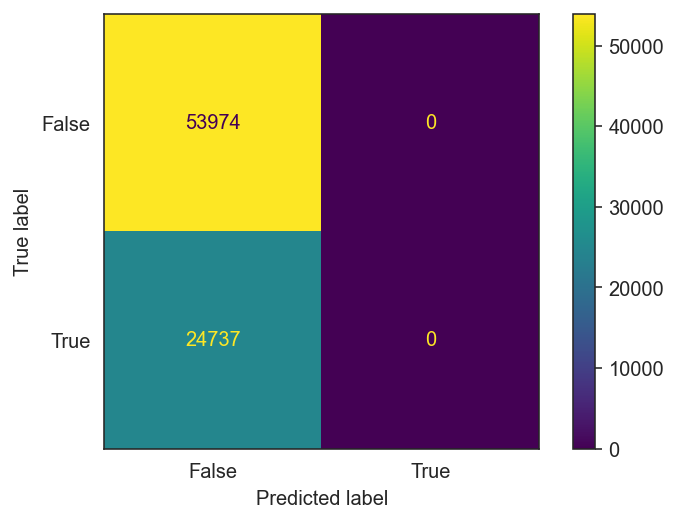

In [19]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(estimator=dummy, X=X_train, y_true=y_bin_train)

In [20]:
precision_score(y_true=y_bin_train, y_pred=dummy.predict(X_train))

/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [21]:
recall_score(y_true=y_bin_train, y_pred=dummy.predict(X_train))

0.0

# Model that can read

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [23]:
preprocessor = DataFrameMapper([
    ('text', TfidfVectorizer(
            min_df=.05, max_df=.5, token_pattern=r'[A-Za-z]{2,}', stop_words='english'
    ))
], input_df=True, df_out=True).fit(X_train)
preprocessor.transform(X_train.sample(5))

,text_access,text_add,text_application,text_attached,text_bit,text_build,text_built,text_button,text_case,text_change,...,text_vm,text_void,text_want,text_way,text_window,text_windows,text_work,text_working,text_works,text_xml
70992,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
62220,0.408919,0.0,0.0,0.000000,0.00000,0.000000,0.198471,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
12316,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.303635,0.0,0.0,0.000000,0.0,0.298717,0.0,0.0
75515,0.000000,0.0,0.0,0.373292,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
94753,0.000000,0.0,0.0,0.000000,0.17829,0.141097,0.191342,0.395654,0.0,0.0,...,0.182616,0.0,0.000000,0.0,0.0,0.164819,0.0,0.191363,0.0,0.0


In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [25]:
lr = make_pipeline(preprocessor.set_params(df_out=False), LogisticRegression())
lr.fit(X_train, y_bin_train)

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[('text',
                                            TfidfVectorizer(max_df=0.5,
                                                            min_df=0.05,
                                                            stop_words='english',
                                                            token_pattern='[A-Za-z]{2,}'))],
                                 input_df=True)),
                ('logisticregression', LogisticRegression())])

In [26]:
lr.predict(X_train).all()

False

In [27]:
accuracy_score(y_true=y_bin_train, y_pred=lr.predict(X_train))

0.7384990662042155

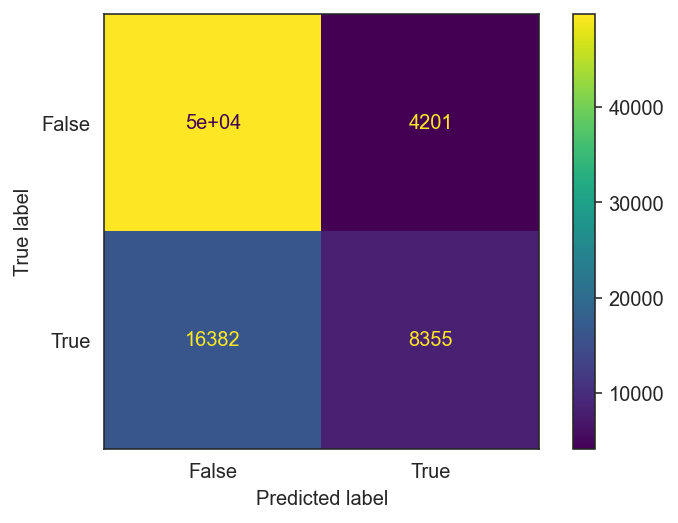

In [28]:
plot_confusion_matrix(estimator=lr, X=X_train, y_true=y_bin_train)

In [29]:
precision_score(y_true=y_bin_train, y_pred=lr.predict(X_train))

0.6654189232239567

In [30]:
recall_score(y_true=y_bin_train, y_pred=lr.predict(X_train))

0.3377531632776812

In [31]:
f1_score(y_true=y_bin_train, y_pred=lr.predict(X_train))

0.4480733649746601

# GridSearch for model parameters

In [32]:
from sklearn.model_selection import ParameterGrid

In [33]:
param_grid = dict(min_df=[.05, .1], max_df=[.2, .3, .5])
param_grid

{'min_df': [0.05, 0.1], 'max_df': [0.2, 0.3, 0.5]}

## Manual search

**Task**: code the grid search =)

In [41]:
results = []
for params in ParameterGrid(param_grid):
    print(params)
    ...

{'max_df': 0.2, 'min_df': 0.05}
{'max_df': 0.2, 'min_df': 0.1}
{'max_df': 0.3, 'min_df': 0.05}
{'max_df': 0.3, 'min_df': 0.1}
{'max_df': 0.5, 'min_df': 0.05}
{'max_df': 0.5, 'min_df': 0.1}


In [46]:
results = pd.DataFrame(results)
results
# results.drop(columns='estimator').sort_values('test_recall').style.bar(vmin=0, vmax=1)

,params,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall
3,"{'max_df': 0.3, 'min_df': 0.1}",0.715783,0.712554,0.641015,0.644635,0.193178,0.191492
5,"{'max_df': 0.5, 'min_df': 0.1}",0.716355,0.713736,0.643388,0.649798,0.194814,0.194522
1,"{'max_df': 0.2, 'min_df': 0.1}",0.714957,0.712516,0.627745,0.631599,0.202299,0.205914
0,"{'max_df': 0.2, 'min_df': 0.05}",0.739109,0.735269,0.660147,0.659030,0.329952,0.327718
2,"{'max_df': 0.3, 'min_df': 0.05}",0.740532,0.736298,0.663685,0.662518,0.333838,0.329051
4,"{'max_df': 0.5, 'min_df': 0.05}",0.741116,0.735841,0.664512,0.660584,0.336374,0.329051


Short reminder: precision and recall are threshold-dependent, it is better to use sth elsee for cross-validation.

In [51]:
best_estimator = results.loc[results.test_recall.idxmax()].estimator

In [66]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_bin_test, best_estimator.predict_proba(X_test['text'])[:,1])

In [67]:
recall_score(y_bin_test, best_estimator.predict(X_test['text']))

0.3290510241182887

In [59]:
import plotly.express as px

In [68]:
px.line(y=precision[:-1], x=recall[:-1], text=thresholds, labels=dict(x='recall', y='precision'))

## Automated search

In [42]:
from sklearn.model_selection import GridSearchCV

In [77]:
pipe = make_pipeline(
        TfidfVectorizer(token_pattern=r'[A-Za-z]{2,}', stop_words='english'),
        LogisticRegression(penalty='none')
    )
cv = GridSearchCV(
    estimator=pipe,
    param_grid=dict(min_df=[.05, .02], max_df=[.1, .3, .6]),
    scoring=,
    refit=False,
    verbose=5
)

In [78]:
cv.fit(X_train['text'], y_bin_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.05; precision: (test=0.607) recall: (test=0.217) total time=   8.2s
[CV 2/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.05; precision: (test=0.618) recall: (test=0.214) total time=   8.0s
[CV 3/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.05; precision: (test=0.612) recall: (test=0.208) total time=   8.1s
[CV 4/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.05; precision: (test=0.615) recall: (test=0.220) total time=   8.1s
[CV 5/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.05; precision: (test=0.616) recall: (test=0.199) total time=   8.2s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 1/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.02; precision: (test=0.707) recall: (test=0.411) total time=   8.6s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 2/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.02; precision: (test=0.704) recall: (test=0.409) total time=   8.8s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 3/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.02; precision: (test=0.710) recall: (test=0.414) total time=   8.8s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 4/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.02; precision: (test=0.713) recall: (test=0.418) total time=   8.4s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 5/5] END tfidfvectorizer__max_df=0.1, tfidfvectorizer__min_df=0.02; precision: (test=0.720) recall: (test=0.418) total time=   8.8s
[CV 1/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.05; precision: (test=0.650) recall: (test=0.333) total time=   8.4s
[CV 2/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.05; precision: (test=0.657) recall: (test=0.323) total time=   8.4s
[CV 3/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.05; precision: (test=0.649) recall: (test=0.338) total time=   8.1s
[CV 4/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.05; precision: (test=0.672) recall: (test=0.339) total time=   8.1s
[CV 5/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.05; precision: (test=0.665) recall: (test=0.329) total time=   8.2s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 1/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.02; precision: (test=0.728) recall: (test=0.464) total time=   8.3s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 2/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.02; precision: (test=0.721) recall: (test=0.457) total time=   8.4s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 3/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.02; precision: (test=0.720) recall: (test=0.462) total time=   8.5s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 4/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.02; precision: (test=0.737) recall: (test=0.469) total time=   8.7s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 5/5] END tfidfvectorizer__max_df=0.3, tfidfvectorizer__min_df=0.02; precision: (test=0.736) recall: (test=0.464) total time=   8.5s
[CV 1/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.05; precision: (test=0.654) recall: (test=0.335) total time=   8.6s
[CV 2/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.05; precision: (test=0.655) recall: (test=0.326) total time=   9.1s
[CV 3/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.05; precision: (test=0.648) recall: (test=0.337) total time=   9.4s
[CV 4/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.05; precision: (test=0.676) recall: (test=0.342) total time=   9.6s
[CV 5/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.05; precision: (test=0.666) recall: (test=0.330) total time=   9.3s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 1/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.02; precision: (test=0.728) recall: (test=0.462) total time=   9.4s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 2/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.02; precision: (test=0.720) recall: (test=0.459) total time=  10.0s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 3/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.02; precision: (test=0.722) recall: (test=0.461) total time=   9.2s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 4/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.02; precision: (test=0.734) recall: (test=0.470) total time=   9.1s


/Users/stacymiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 5/5] END tfidfvectorizer__max_df=0.6, tfidfvectorizer__min_df=0.02; precision: (test=0.738) recall: (test=0.465) total time=   9.2s


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english',
                                                        token_pattern='[A-Za-z]{2,}')),
                                       ('logisticregression',
                                        LogisticRegression(penalty='none'))]),
             param_grid={'tfidfvectorizer__max_df': [0.1, 0.3, 0.6],
                         'tfidfvectorizer__min_df': [0.05, 0.02]},
             refit=False, scoring=['precision', 'recall'], verbose=5)

How to speed up:

- `GridSearchCV(n_jobs=-1)` would parallel the fitting process
- smaller sample would decrease the fit time
- smaller number of parameters (greedy strategy) would allow to fit less models

In [88]:
pd.DataFrame(cv.cv_results_)[['params', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_precision,mean_test_recall
0,"{'tfidfvectorizer__max_df': 0.1, 'tfidfvectori...",0.613607,0.211502
1,"{'tfidfvectorizer__max_df': 0.1, 'tfidfvectori...",0.710863,0.414004
2,"{'tfidfvectorizer__max_df': 0.3, 'tfidfvectori...",0.658375,0.332160
3,"{'tfidfvectorizer__max_df': 0.3, 'tfidfvectori...",0.728176,0.463209
4,"{'tfidfvectorizer__max_df': 0.6, 'tfidfvectori...",0.659675,0.333960
5,"{'tfidfvectorizer__max_df': 0.6, 'tfidfvectori...",0.728325,0.463454


# Decision trees

In [89]:
from sklearn.tree import DecisionTreeClassifier
dt = make_pipeline(
        TfidfVectorizer(token_pattern=r'[A-Za-z]{2,}', stop_words='english', max_df=.3, min_df=.2),
        DecisionTreeClassifier()
    )

In [90]:
dt.fit(X_train['text'], y_bin_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.3, min_df=0.2, stop_words='english',
                                 token_pattern='[A-Za-z]{2,}')),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

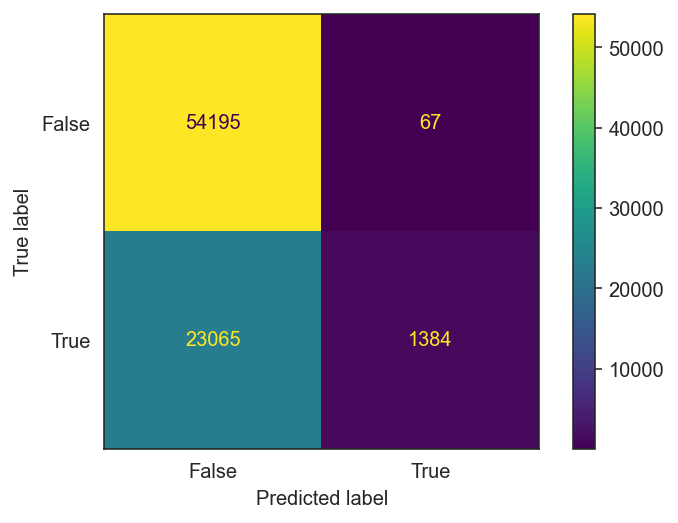

In [92]:
plot_confusion_matrix(estimator=dt, X=X_train['text'], y_true=y_bin_train)

In [94]:
precision_score(y_true=y_bin_train, y_pred=dt.predict(X_train['text']))

0.9538249483115093

In [96]:
recall_score(y_true=y_bin_train, y_pred=dt.predict(X_train['text']))

0.056607632213996485

In [112]:
precision_score(y_true=y_bin_test, y_pred=dt.predict(X_test['text']))

0.2898550724637681

In [113]:
recall_score(y_true=y_bin_test, y_pred=dt.predict(X_test['text']))

0.009695794449157679

The model above is simply overfitted. WHat should we do with it?

In [98]:
dt.named_steps['decisiontreeclassifier'].get_depth()

48

In [34]:
dt = make_pipeline(
        TfidfVectorizer(token_pattern=r'[A-Za-z]{2,}', stop_words='english', max_df=.3, min_df=.2),
        DecisionTreeClassifier(max_depth=40, min_samples_leaf=10)
    )
dt.fit(X_train['text'], y_bin_train)

NameError: name 'DecisionTreeClassifier' is not defined

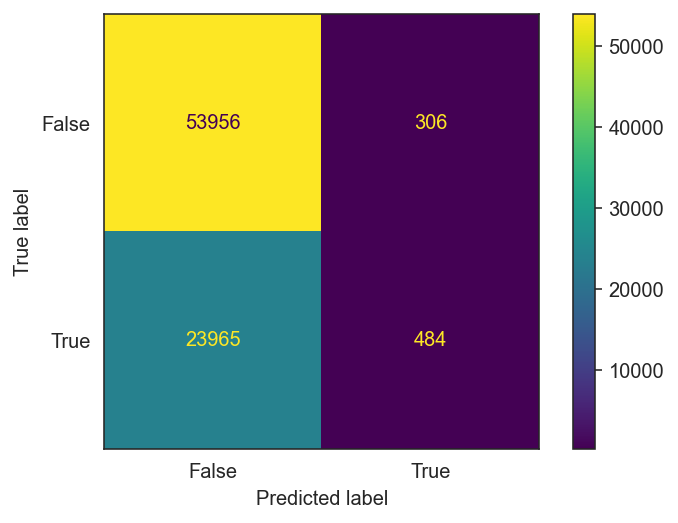

In [111]:
plot_confusion_matrix(estimator=dt, X=X_train['text'], y_true=y_bin_train)

In [114]:
precision_score(y_true=y_bin_train, y_pred=dt.predict(X_train['text']))

0.6126582278481013

In [ ]:
recall_score(y_true=y_bin_train, y_pred=dt.predict(X_train['text']))

**Task**: run grid search to find the best parameters for the Decision Tree model